# Exploratory Data Analysis: COVID-19 Misinformation Spread

This notebook explores how misinformation and factual content differ in their
temporal behavior, engagement patterns, and spread characteristics on Twitter.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [3]:
df = pd.read_csv("../data/raw/covid_misinfo_raw.csv")
df.head()


,id,time,friends,followers,label,graph_id
0,582746618,35312,8,6,0,1069
1,83528167,22636,9,7,0,1069
2,611354762,32483,7,9,0,1069
3,129109380,115680,8,6,0,1069
4,4826186,32264,12,10,0,1069


In [4]:
df.shape


(195843, 6)

In [5]:
df.columns

Index(['id', 'time', 'friends', 'followers', 'label', 'graph_id'], dtype='object')

The dataset contains 195843 rows and 6 columns.
Each row represents a tweet used to analyze misinformation spread behavior.


In [6]:
df["label"].value_counts()


label
0    157146
1     38697
Name: count, dtype: int64

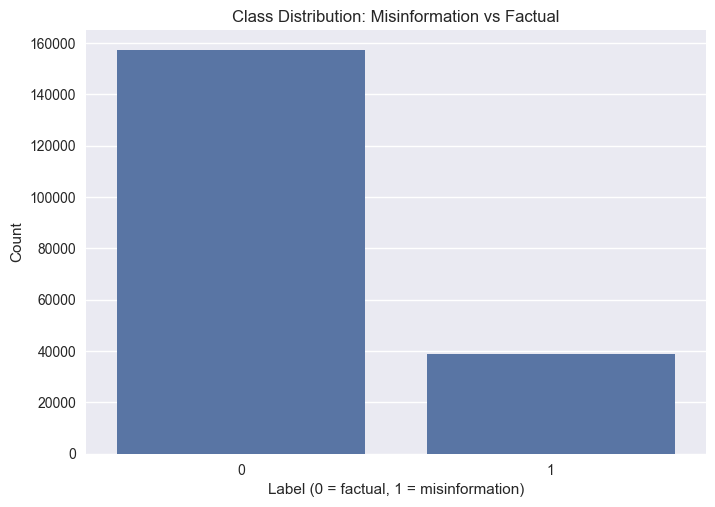

In [7]:
sns.countplot(data=df, x="label")
plt.title("Class Distribution: Misinformation vs Factual")
plt.xlabel("Label (0 = factual, 1 = misinformation)")
plt.ylabel("Count")
plt.show()


The dataset is imbalanced as it contains more factual tweets than misinformation tweets. 

In [8]:
from sklearn.model_selection import train_test_split

X = df[["time", "friends", "followers"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [10]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89     31430
           1       0.17      0.00      0.00      7739

    accuracy                           0.80     39169
   macro avg       0.49      0.50      0.45     39169
weighted avg       0.68      0.80      0.71     39169



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_balanced = LogisticRegression(max_iter=1000, class_weight="balanced")
model_balanced.fit(X_train, y_train)

y_pred_bal = model_balanced.predict(X_test)
print(classification_report(y_test, y_pred_bal))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31430
           1       0.20      1.00      0.33      7739

    accuracy                           0.20     39169
   macro avg       0.10      0.50      0.16     39169
weighted avg       0.04      0.20      0.07     39169



/Users/karanbindal/misinformation-spread-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/karanbindal/misinformation-spread-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/karanbindal/misinformation-spread-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

In [13]:
import numpy as np
import pandas as pd

# Predict probabilities for class 1 (misinformation)
y_proba = model.predict_proba(X_test)[:, 1]

# Quick sanity check
pd.Series(y_proba).describe()


count    39169.000000
mean         0.211859
std          0.052865
min          0.072879
25%          0.172982
50%          0.206599
75%          0.239773
max          0.631102
dtype: float64

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def eval_threshold(thresh):
    y_pred_t = (y_proba >= thresh).astype(int)

    cm = confusion_matrix(y_test, y_pred_t)
    tn, fp, fn, tp = cm.ravel()

    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame([eval_threshold(t) for t in thresholds])

results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.197784,0.197496,0.998966,0.329793,7731,31414,16,8
1,0.2,0.470627,0.190040,0.514795,0.277602,3984,16980,14450,3755
2,0.3,0.770354,0.196031,0.052332,0.082611,405,1661,29769,7334
3,0.4,0.797850,0.172161,0.006073,0.011732,47,226,31204,7692
4,0.5,0.800914,0.168539,0.001938,0.003832,15,74,31356,7724
5,0.6,0.802344,0.000000,0.000000,0.000000,0,3,31427,7739
6,0.7,0.802420,0.000000,0.000000,0.000000,0,0,31430,7739
7,0.8,0.802420,0.000000,0.000000,0.000000,0,0,31430,7739
8,0.9,0.802420,0.000000,0.000000,0.000000,0,0,31430,7739


In [ ]:
FINAL_THRESHOLD = 0.2
y_pred_final = (y_proba >= FINAL_THRESHOLD).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final, zero_division=0))


[[14450 16980]
 [ 3755  3984]]
              precision    recall  f1-score   support

           0       0.79      0.46      0.58     31430
           1       0.19      0.51      0.28      7739

    accuracy                           0.47     39169
   macro avg       0.49      0.49      0.43     39169
weighted avg       0.67      0.47      0.52     39169



Selecting a Threshold

The logistic regression model outputs probabilities for the misinformation class. The default 0.5 threshold outputed 0.0 recall for misinformation due to the imbalance in the data. 
To find a better threshold we found precision, recall, and F1 score for thresholds between 0.1 and 0.9 and chose 0.2 because it provided the best balance between recall and precision.

In [16]:
import pandas as pd
import numpy as np

feature_names = X.columns
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "odds_ratio": np.exp(coefficients)
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient,odds_ratio
2,followers,2.254607e-02,1.022802
0,time,3.537119e-09,1.000000
1,friends,-1.467992e-01,0.863467


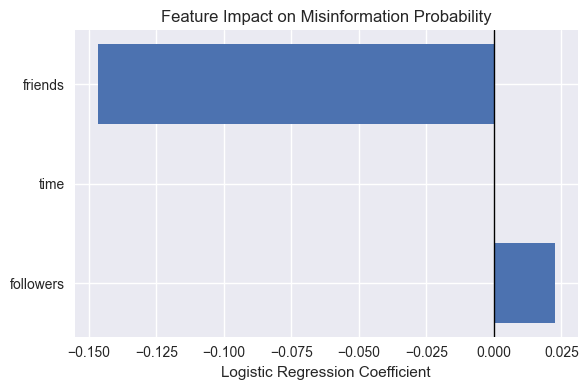

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Feature Impact on Misinformation Probability")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


In this notebook, a baseline logistic regression model was trained using only tweet metadata. While the model achieved high overall accuracy, this performance is largely driven by class imbalance in the dataset.

Evaluation across multiple probability thresholds revealed poor precision and recall for misinformation detection, indicating limited separability using metadata alone.

These results establish a baseline and demonstrate that metadata alone is insufficient for reliable misinformation detection. Future steps will incorporate tweet text and network-based features to improve predictive performance.